# Decision boundary for linear perceptron

Below are the code and data for linear classification.

In [1]:
import numpy as np


class Perceptron(object):
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.

    """
    def __init__(self, eta=0.01, n_iter=10):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        self.w_ = np.zeros(1 + X.shape[1])
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi
                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

In [2]:
import pandas as pd

#data_src = '../datasets/iris/iris.data'
data_src = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

df = pd.read_csv(data_src, header=None)

df.tail()

,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


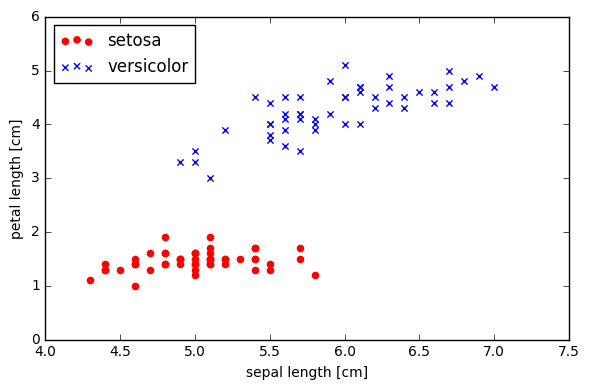

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# select setosa and versicolor
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)

# extract sepal length and petal length
X = df.iloc[0:100, [0, 2]].values

# plot data
plt.scatter(X[:50, 0], X[:50, 1],
            color='red', marker='o', label='setosa')
plt.scatter(X[50:100, 0], X[50:100, 1],
            color='blue', marker='x', label='versicolor')

plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [4]:
ppn = Perceptron(eta=0.1, n_iter=10)

ppn = ppn.fit(X, y)

In [5]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

## Question (50 points)

As shown in function <font color='blue'>plot_decision_regions</font>, the decision regions can be visualized by dense sampling via meshgrid.
However, if the grid resolution is not enough, as artificially set below, the boundary will appear inaccurate.

Implement function <font color='blue'>plot_decision_boundary</font> below to analytically compute and plot the decision boundary.


In [6]:
def plot_decision_boundary(X, y, classifier):    
    
    # replace the two lines below with your code
    x1_interval = [X[:, 0].min() - 1, X[:, 0].max() + 1]
    x2_interval = [1/classifier.w_[2] * (-classifier.w_[0]-classifier.w_[1]*(X[:,0].min()-1)), 1/classifier.w_[2]* (-classifier.w_[0]-classifier.w_[1]*(X[:,0].max()+1))]

    plt.plot(x1_interval, x2_interval, color='green', linewidth=4, label='boundary')

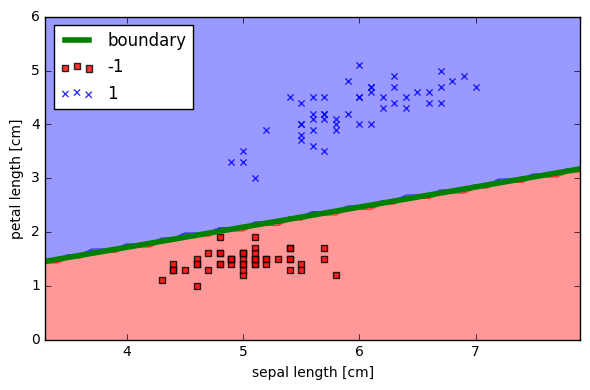

In [7]:
low_res = 0.1
# intentional for this exercise
plot_decision_regions(X, y, classifier=ppn, resolution=low_res)
plot_decision_boundary(X, y, classifier=ppn)

plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

plt.tight_layout()
# plt.savefig('./perceptron_2.png', dpi=300)
plt.show()

# Stochastic gradient descent

Below is the AdalineSGD code.
Notice that it does not compute costs for <font color='blue'>partial_fit</font>.
We are going to do that for this exercise to study the behavior of stochastic gradient descent.

In [8]:
from numpy.random import seed

class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int (default: None)
        Set random state for shuffling and initializing the weights.
        
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state:
            seed(random_state)
        self.cost_ = []
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            self.cost = self._update_weights(X,y)
        else:
            self.cost = self._update_weights(X,y)
        self.cost_.append(self.cost/len(y))
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to zeros"""
        self.w_ = np.zeros(1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = [self.net_input(x) for x in xi]
        error = (target - output)
        self.w_[1:] += self.eta * xi.T.dot(error)
        self.w_[0] += self.eta * sum(error)
        cost = 0.5 * sum(error**2)
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)
    
   
    

## Question (50 points)

Modify the code above so that we can visualize the costs with different batch sizes.
Note that each batch size should have a separate plot for average cost (y axis) versus number of trained samples (x axis).
What you find out from your experiments?

In [9]:
# standardize features
X_std = np.copy(X)
X_std[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
X_std[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()

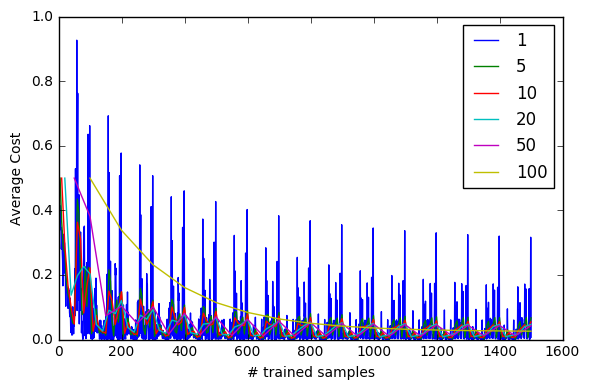

In [10]:
iterations = 15
batch_sizes = [1, 5, 10, 20, 50, 100]

for batch_size in batch_sizes:
    ada = AdalineSGD(n_iter=0, eta=0.01, random_state=1)
    for iteration in range(iterations):    
        num_batches = np.ceil(y.ravel().shape[0]/batch_size).astype(int)
        for batch_index in range(num_batches):
            start_index = batch_index*batch_size
            end_index = start_index + batch_size
            ada.partial_fit(X_std[start_index:end_index, :], y[start_index:end_index]) 
            
    plt.plot([batch_size * x for x in range(1, len(ada.cost_) + 1)], ada.cost_, label=str(batch_size))
if len(batch_sizes) > 0: 
    plt.xlabel('# trained samples')
    plt.ylabel('Average Cost')
    plt.legend(loc='best')

    plt.tight_layout()
    # plt.savefig('./adaline_5.png', dpi=300)
    plt.show()

For the same batch size, average cost has a tendency to decrease with regard of the increase of iterations. 
For different batch size but with same trained samples, the larger the batch size, the smaller the average cost, with regard of the increase of iterations..